# Astral II dataset

Mamie Wang 2021/03/22

Use 1000 taxon data from ASTRAL II paper.

1. Load and extract one simulation with taxon = 1000 

`tar -tvf estimated-gene-trees.tar.bz`

`tar xf estimated-gene-trees.tar.bz model.1000.2000000.0.000001/01/estimatedgenetre.gz`

`tar xf true_species_trees.tar.bz model.1000.2000000.0.000001/01/s_tree.trees`

2. read in the estimated gene trees (input for the model) and compute the internode distance

3. compare neighbor joining and STDR

In [1]:
import pandas as pd
import dendropy
import numpy as np
import time

In [2]:
# gene trees
gene_trees = pd.read_csv("~/scratch60/ASTRALII/model.1000.2000000.0.000001/01/estimatedgenetre.gz",
                       sep = "\t", header = None).values[:,0]
tree = dendropy.Tree.get(data = gene_trees[1], schema="newick")
tree_namespace = tree.taxon_namespace
n_taxa = len(tree_namespace)

In [3]:
tree_namespace_labels = [x.label for x in tree_namespace]

In [4]:
dists = []
# summarize over 10 gene trees
for k in range(10):
    print(k)
    tree = dendropy.Tree.get(data = gene_trees[k], schema="newick", taxon_namespace = tree_namespace)
    pdm = dendropy.PhylogeneticDistanceMatrix.from_tree(tree)
    dist = np.zeros((n_taxa, n_taxa))
    for i in range(n_taxa):
        for j in range(i+1,n_taxa):
            dist[i,j] = pdm.distance(tree_namespace[i], tree_namespace[j])
    dist = dist + dist.T
    dists.append(dist)

0
1
2
3
4
5
6
7
8
9


In [5]:
dists_arr = np.array(dists)

In [6]:
# take the average of the distance matrix
int_node_dist = np.mean(dists_arr, axis = 0)

In [76]:
int_node_dist_median = np.median(dists_arr, axis = 0)

(array([2.27900e+03, 6.44400e+03, 1.06386e+05, 4.19992e+05, 3.45658e+05,
        9.95660e+04, 1.81280e+04, 3.22600e+03, 3.04000e+02, 1.80000e+01]),
 array([0.       , 0.1895298, 0.3790596, 0.5685894, 0.7581192, 0.947649 ,
        1.1371788, 1.3267086, 1.5162384, 1.7057682, 1.895298 ]),
 <a list of 10 Patch objects>)

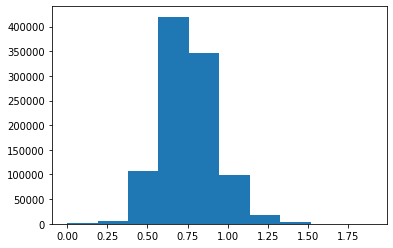

In [79]:
plt.hist(int_node_dist.flatten())

(array([4.80000e+01, 5.88000e+02, 3.51000e+03, 1.74360e+04, 1.25006e+05,
        4.48182e+05, 3.68592e+05, 3.81210e+04, 5.14000e+02, 4.00000e+00]),
 array([-0.756445 , -0.6497089, -0.5429728, -0.4362367, -0.3295006,
        -0.2227645, -0.1160284, -0.0092923,  0.0974438,  0.2041799,
         0.310916 ]),
 <a list of 10 Patch objects>)

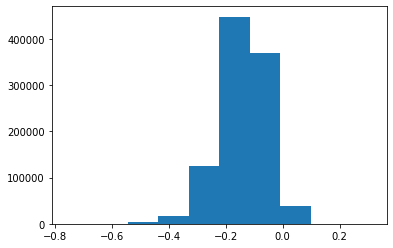

In [81]:
plt.hist((int_node_dist_median - int_node_dist).flatten())

In [7]:
int_node_dist.shape

(1001, 1001)

In [15]:
import matplotlib.pyplot as plt

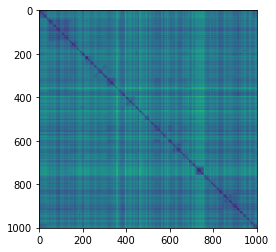

In [16]:
plt.imshow(int_node_dist)

(array([2.27900e+03, 6.44400e+03, 1.06386e+05, 4.19992e+05, 3.45658e+05,
        9.95660e+04, 1.81280e+04, 3.22600e+03, 3.04000e+02, 1.80000e+01]),
 array([0.       , 0.1895298, 0.3790596, 0.5685894, 0.7581192, 0.947649 ,
        1.1371788, 1.3267086, 1.5162384, 1.7057682, 1.895298 ]),
 <a list of 10 Patch objects>)

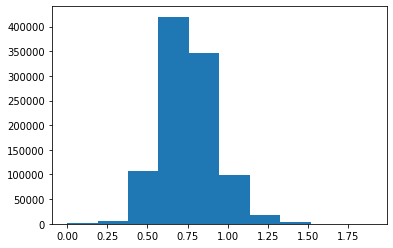

In [71]:
plt.hist(int_node_dist.flatten())

In [18]:
# Load the true tree
tree_true = dendropy.Tree.get(path = "/home/mw957/scratch60/ASTRALII/model.1000.2000000.0.000001/01/s_tree.trees",
        schema="newick", taxon_namespace=tree_namespace)

# Neighbor joining

In [11]:
import sys, os

sys.path.append("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/spectraltree")

import reconstruct_tree
import utils

In [90]:
taxa_metadata = utils.TaxaMetadata(tree_namespace, tree_namespace_labels)

NJ_dist_mat = utils.array2distance_matrix(int_node_dist, taxa_metadata)

NJ_tree = NJ_dist_mat.nj_tree()

KeyboardInterrupt: 

In [75]:
RF,F1 = reconstruct_tree.compare_trees(NJ_tree, tree_true)
print("RF = ",RF)
print("F1% = ",F1)

RF =  410
F1% =  89.75


In [74]:
snj = reconstruct_tree.SpectralNeighborJoining(reconstruct_tree.JC_similarity_matrix)   


In [75]:
tree_snj = snj.reconstruct_from_similarity(int_node_sim, taxa_metadata = taxa_metadata)

In [76]:
RF,F1 = reconstruct_tree.compare_trees(tree_snj, tree_true)

In [77]:
print("RF = ",RF)
print("F1% = ",F1)

RF =  608
F1% =  84.8


## Neighbor joining (median dist)

In [91]:
taxa_metadata = utils.TaxaMetadata(tree_namespace, tree_namespace_labels)

NJ_dist_mat = utils.array2distance_matrix(int_node_dist_median, taxa_metadata)

NJ_tree = NJ_dist_mat.nj_tree()

In [92]:
RF,F1 = reconstruct_tree.compare_trees(NJ_tree, tree_true)
print("RF = ",RF)
print("F1% = ",F1)

RF =  624
F1% =  84.39999999999999


## STDR

In [88]:
np.mean(int_node_dist[~np.eye(int_node_dist.shape[0],dtype=bool)])

0.7559732974825174

In [8]:
int_node_sim = np.exp(-int_node_dist)

(array([   782.,  18342., 136822., 383994., 345076., 100576.,  11426.,
          2466.,   1118.,    398.]),
 array([0.15027355, 0.23334274, 0.31641194, 0.39948113, 0.48255032,
        0.56561952, 0.64868871, 0.73175791, 0.8148271 , 0.89789629,
        0.98096549]),
 <a list of 10 Patch objects>)

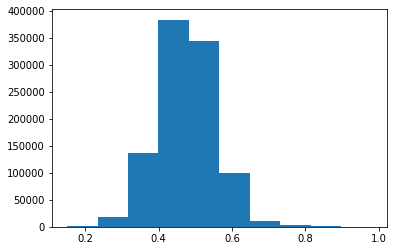

In [78]:
plt.hist(int_node_sim[~np.eye(int_node_dist.shape[0],dtype=bool)].flatten())

In [32]:
W = int_node_sim # - np.eye(int_node_sim.T.shape[0])

# Compute random walk Laplacian matrix
row_sum = np.sum(W, axis = 0)
D = np.diag(1/row_sum)
Ms = D @ W

w, v = np.linalg.eig(Ms)

v_ordered = v[:, np.argsort(w)][:,::-1]

In [27]:
import matplotlib.pyplot as plt

In [58]:
partition = reconstruct_tree.partition_taxa(v_ordered[:,1], int_node_sim, num_gaps = 5, min_split = 30)

In [59]:
np.sum(partition)

39

In [60]:
len(partition)

1001

In [61]:
def check_is_bipartition(tree, bool_partition):
    bipartitions = [str(x)[::-1] for x in tree.encode_bipartitions()]
    partition_1 = "".join(list(bool_partition.astype('int').astype('str')))
    partition_2 = "".join(list((1 - bool_partition).astype('int').astype('str')))
    is_bipartition = (partition_1 in bipartitions) or (partition_2 in bipartitions)
    return is_bipartition

In [62]:
# check if it is bipartition
check_is_bipartition(tree_true, partition)

True

In [68]:
import importlib
importlib.reload(reconstruct_tree)

<module 'reconstruct_tree' from '/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/spectraltree/reconstruct_tree.py'>

In [63]:
second_par_idx = ~partition 

In [66]:
int_node_sim_2 = int_node_sim[second_par_idx,:][:, second_par_idx]

In [67]:
W = int_node_sim_2
row_sum = np.sum(W, axis = 0)
D = np.diag(1/row_sum)
Ms = D @ W

w, v = np.linalg.eig(Ms)

v_ordered = v[:, np.argsort(w)][:,::-1]

In [ ]:
partition = reconstruct_tree.partition_taxa(v_ordered[:,1], int_node_sim_2, num_gaps = 5, min_split = 30)

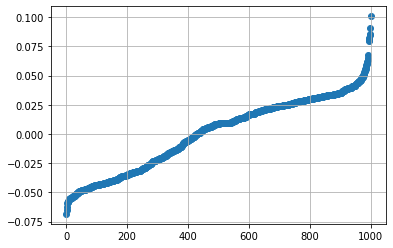

In [93]:
plt.grid()
plt.scatter(np.arange(1001), np.sort(v_ordered[:,1]))

(array([  1.,   0.,   0.,   2.,   0.,   6., 425., 471.,  90.,   6.]),
 array([0.       , 0.1895298, 0.3790596, 0.5685894, 0.7581192, 0.947649 ,
        1.1371788, 1.3267086, 1.5162384, 1.7057682, 1.895298 ]),
 <a list of 10 Patch objects>)

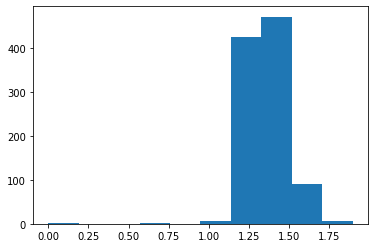

In [85]:
plt.hist(int_node_dist[:,357])

(array([2.27900e+03, 6.44400e+03, 1.06386e+05, 4.19992e+05, 3.45658e+05,
        9.95660e+04, 1.81280e+04, 3.22600e+03, 3.04000e+02, 1.80000e+01]),
 array([0.       , 0.1895298, 0.3790596, 0.5685894, 0.7581192, 0.947649 ,
        1.1371788, 1.3267086, 1.5162384, 1.7057682, 1.895298 ]),
 <a list of 10 Patch objects>)

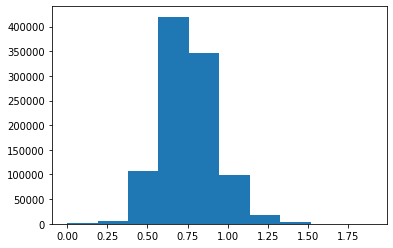

In [86]:
plt.hist(int_node_dist.flatten())

In [ ]:
check_is_bipartition(tree_rec, bool_par)

In [88]:
bool_par = np.repeat(False, 1001)
bool_par[357] = True

In [41]:
import importlib
importlib.reload(reconstruct_tree)

<module 'reconstruct_tree' from '/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/spectraltree/reconstruct_tree.py'>

In [73]:
spectral_method = reconstruct_tree.SpectralTreeReconstruction(reconstruct_tree.NeighborJoining, int_node_sim)

tree_rec = spectral_method.deep_spectral_tree_reconstruction(1, int_node_sim, 
                                                            taxa_metadata = taxa_metadata, 
                                                            threshhold = 500, num_gaps = 1,
                                                            min_split = 1, verbose = True)

870292.0 KB
partition
L1 size:  39
L2 size:  962
870296.0 KB
partition
L1 size:  98
L2 size:  864
870296.0 KB
partition
L1 size:  812
L2 size:  52
870296.0 KB
--- 0.04047989845275879 seconds ---
870296.0 KB
partition
L1 size:  779
L2 size:  33
870296.0 KB
--- 0.013480424880981445 seconds ---
870296.0 KB
partition
L1 size:  764
L2 size:  15
870296.0 KB
--- 0.002950906753540039 seconds ---
870296.0 KB
partition
L1 size:  120
L2 size:  644
870296.0 KB
partition
L1 size:  598
L2 size:  46
870296.0 KB
--- 0.02962970733642578 seconds ---
870296.0 KB
partition
L1 size:  9
L2 size:  589
870296.0 KB
partition
L1 size:  411
L2 size:  178
870296.0 KB
--- 1.1776728630065918 seconds ---
870752.0 KB
--- 13.699061632156372 seconds ---
872844.0 KB
len(bipartitions1) 821
one
one - merging:  1  out of:  411
len(bipartitions2) 355
one - merging:  9  out of:  178
873088.0 KB
--- 0.0014872550964355469 seconds ---
873088.0 KB
len(bipartitions1) 17
one
one - merging:  1  out of:  9
len(bipartitions2) 1177
on

In [75]:
RF,F1 = reconstruct_tree.compare_trees(tree_rec, tree_true)

print("RF = ",RF)
print("F1% = ",F1)

RF =  452
F1% =  88.7


In [42]:
spectral_method = reconstruct_tree.SpectralTreeReconstruction(reconstruct_tree.NeighborJoining, int_node_sim)

tree_rec = spectral_method.deep_spectral_tree_reconstruction(1, int_node_sim, 
                                                            taxa_metadata = taxa_metadata, 
                                                            threshhold = 500, num_gaps = 0,
                                                            min_split = 1, verbose = True)

860644.0 KB
partition
L1 size:  3
L2 size:  998
860644.0 KB
partition
L1 size:  996
L2 size:  2
860644.0 KB
--- 0.0008549690246582031 seconds ---
860644.0 KB
partition
L1 size:  1
L2 size:  995
860644.0 KB
partition
L1 size:  1
L2 size:  994
860644.0 KB
partition
L1 size:  9
L2 size:  985
860668.0 KB
partition
L1 size:  1
L2 size:  984
860668.0 KB
partition
L1 size:  983
L2 size:  1
860668.0 KB
--- 0.001567840576171875 seconds ---
860668.0 KB
partition
L1 size:  2
L2 size:  981
860668.0 KB
partition
L1 size:  14
L2 size:  967
860668.0 KB
partition
L1 size:  6
L2 size:  961
860668.0 KB
partition
L1 size:  2
L2 size:  959
860668.0 KB
partition
L1 size:  920
L2 size:  39
860668.0 KB
--- 0.018627643585205078 seconds ---
860668.0 KB
partition
L1 size:  4
L2 size:  916
860668.0 KB
partition
L1 size:  909
L2 size:  7
860668.0 KB
--- 0.0012586116790771484 seconds ---
860668.0 KB
partition
L1 size:  901
L2 size:  8
860668.0 KB
--- 0.0013780593872070312 seconds ---
860668.0 KB
partition
L1 size:

In [38]:
RF,F1 = reconstruct_tree.compare_trees(tree_rec, tree_true)

print("RF = ",RF)
print("F1% = ",F1)

RF =  1326
F1% =  66.85000000000001


In [88]:
spectral_method = reconstruct_tree.SpectralTreeReconstruction(reconstruct_tree.NeighborJoining, 
                                                              int_node_sim_median)

tree_rec = spectral_method.deep_spectral_tree_reconstruction(1, int_node_sim_median, 
                                                            taxa_metadata = taxa_metadata, 
                                                            threshhold = 500, num_gaps = 1,
                                                            min_split = 30, verbose = True)

976596.0 KB
partition
L1 size:  423
L2 size:  578
922144.0 KB
partition
L1 size:  539
L2 size:  39
932428.0 KB
--- 0.02032184600830078 seconds ---
932428.0 KB
partition
L1 size:  31
L2 size:  508
932428.0 KB
partition
L1 size:  98
L2 size:  410
932428.0 KB
--- 13.678891897201538 seconds ---
932480.0 KB
--- 0.22085237503051758 seconds ---
932480.0 KB
len(bipartitions1) 195
one
one - merging:  1  out of:  98
len(bipartitions2) 819
one
one - merging:  1  out of:  410
932480.0 KB
--- 0.012703895568847656 seconds ---
932480.0 KB
len(bipartitions1) 61
one
one - merging:  1  out of:  31
len(bipartitions2) 1015
one
one - merging:  1  out of:  508
932480.0 KB
len(bipartitions1) 1077
one
one - merging:  1  out of:  539
len(bipartitions2) 77
one - merging:  3  out of:  39
932480.0 KB
--- 14.909506559371948 seconds ---
932480.0 KB
len(bipartitions1) 845
one - merging:  7  out of:  423
len(bipartitions2) 1155
one
one - merging:  1  out of:  578


In [89]:
RF,F1 = reconstruct_tree.compare_trees(tree_rec, tree_true)

print("RF = ",RF)
print("F1% = ",F1)

RF =  732
F1% =  81.69999999999999


In [85]:
int_node_sim_median = np.exp(-int_node_dist_median)